#Import required packages

In [ ]:
#Data loading and processing
import pandas as pd
import re
import pickle

#NLP tools
import nltk
from nltk.corpus import stopwords

#Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np

# Term Frequency Inverse transform
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Machine learning algorithms
from sklearn.svm import SVC
from xgboost import XGBClassifier
import xgboost as xgb

#Evaluation and other tools from sklearn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

#Supress warnings
import warnings
warnings.filterwarnings("ignore")

#Load dataset

In [ ]:
#Load dataset using pandas
df = pd.read_csv('mbti_1.csv')

#Exploratory Data Analysis

##Have a look

In [ ]:
#Print first 5 entries
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


##Post text

In [ ]:
#Text in the first post
df.loc[1,'posts']

"'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||Hello *ENTP Grin*  That's all it takes. Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins.|||This + Lack of Balance and Hand Eye Coordination.|||Real IQ test I score 127. Internet IQ tests are funny. I score 140s or higher.  Now, like the former responses of this thread I will mention that I don't believe in the IQ test. Before you banish...|||You know you're an ENTP when you vanish from a site for a year and a half, return, and find people are still commenting on your posts and liking your ideas/thoughts. You know you're an ENTP when you...|||http://img188.imageshack.us/img188/6422/6020d1f9da

##Missing values

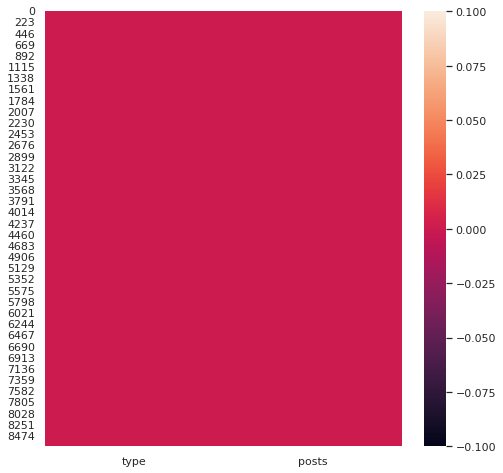

In [ ]:
#Make missing values plot
plt.figure(figsize=(8,8))
sns.set_theme(style='whitegrid', palette='pastel')
sns.heatmap(df.isnull());

##Class distribution

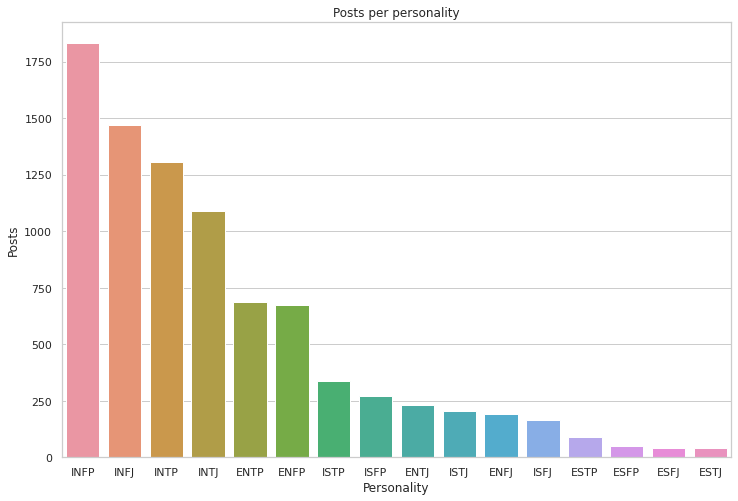

In [ ]:
#Calculate posts per type
Posts = df.groupby(['type']).count().sort_values(by=['posts'],ascending=False)

#Create barchart
plt.figure(figsize = (12,8))
plot = sns.barplot(x=np.array(Posts.index), y = Posts['posts'])
plt.xlabel('Personality')
plt.ylabel('Posts')
plt.title('Posts per personality');

##Words per comment

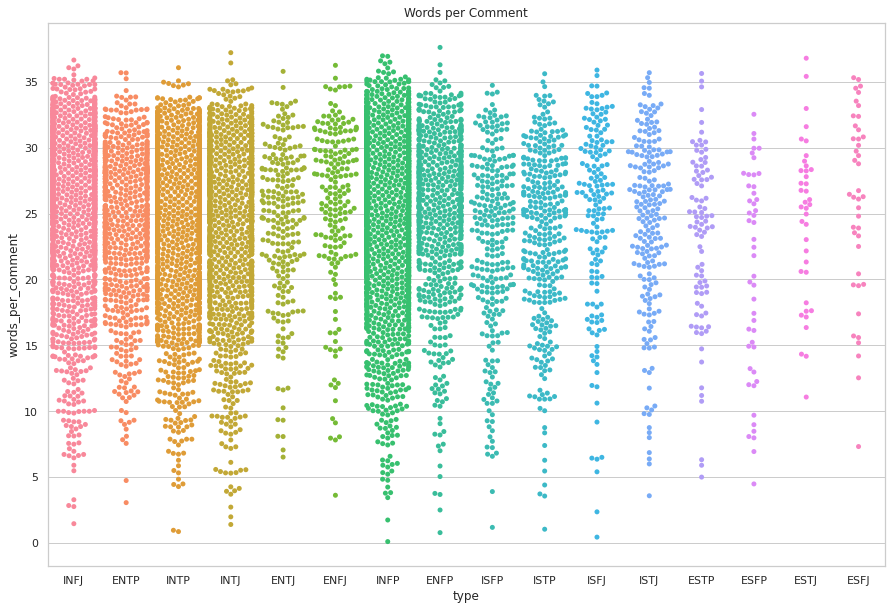

In [ ]:
#Posts by each user
Num_post = 50

#Count words per comment
df['words_per_comment'] = df['posts'].apply(lambda x: len(x.split())/Num_post)

#Plot the count using swarmplot
plt.figure(figsize=(15,10))
sns.swarmplot("type", "words_per_comment", data=df);
plt.title("Words per Comment");

##Posts length

Text(0.5, 1.0, 'Length distribution')

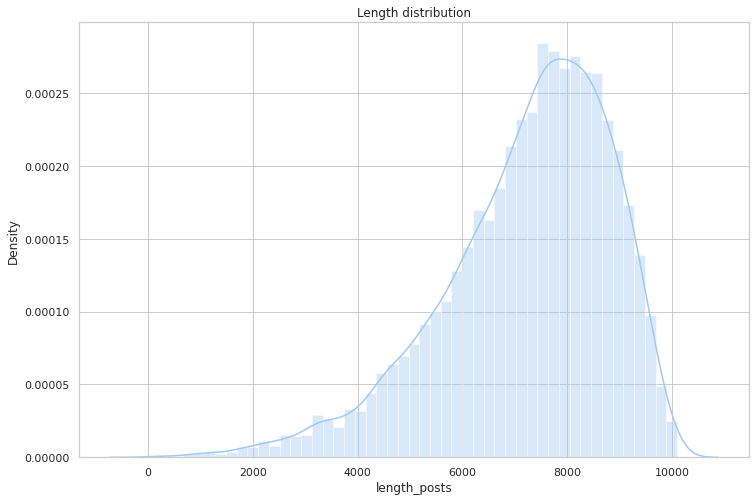

In [ ]:
#Calculate posts length
df["length_posts"] = df["posts"].apply(len)

#Create distribution plot
plt.figure(figsize=(12,8))
sns.distplot(df["length_posts"]).set_title("Length distribution")

##Words Cloud

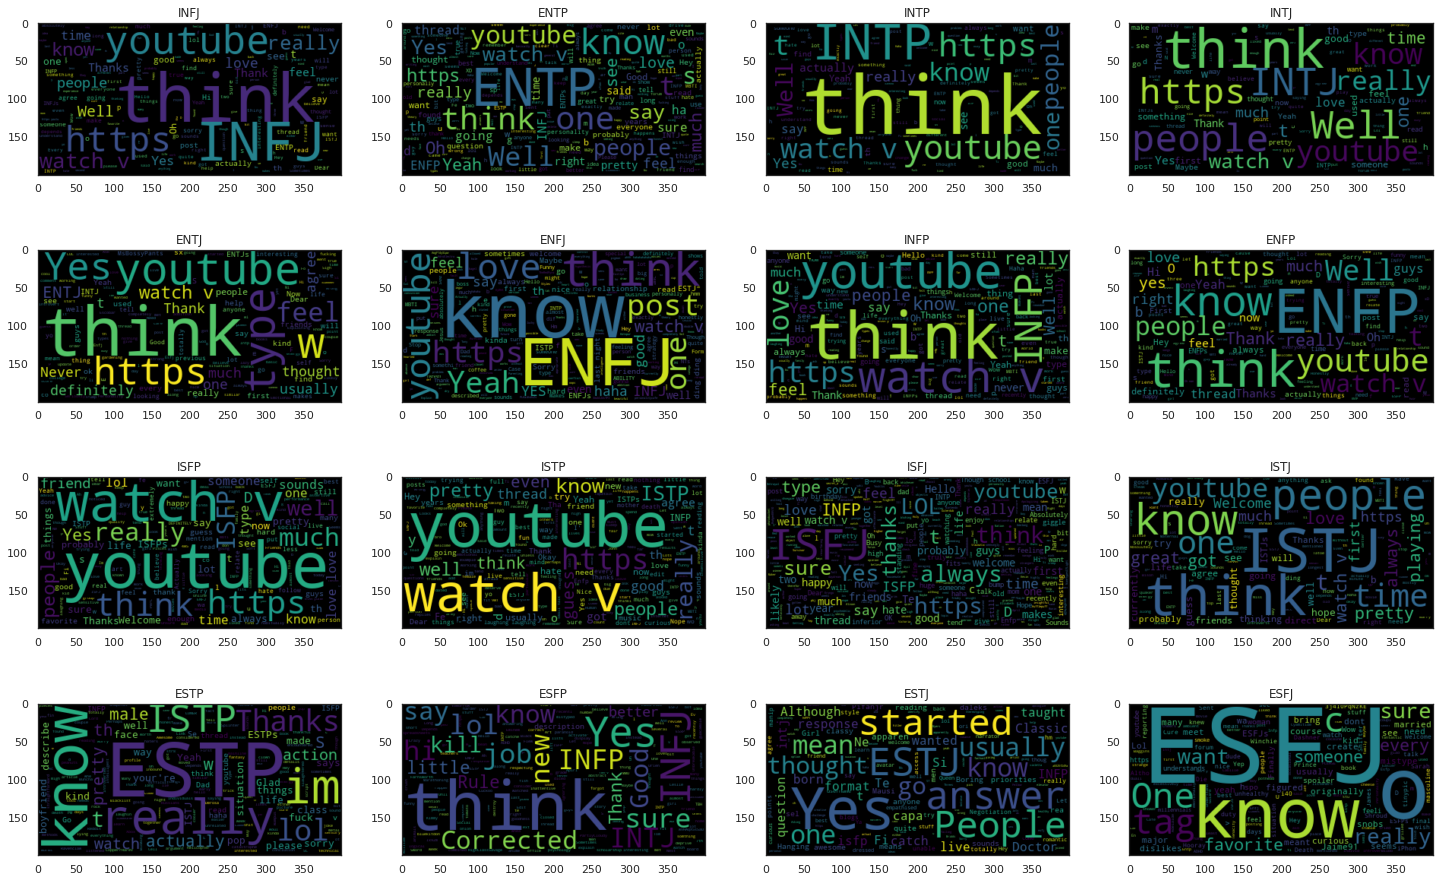

In [ ]:
#Total personality types
total_types = len(df['type'].unique())

#Create word cloud
sns.set_theme(style='white')
fig, ax = plt.subplots(total_types, sharex=True, figsize=(25,total_types))
j = 0

#Iterate over each personality types
for i in df['type'].unique():
    #Get personality
    temp = df[df['type'] == i]
    #Create word cloud
    wordcloud = WordCloud(max_words=1628,relative_scaling=1,normalize_plurals=False).generate(temp['posts'].to_string())
    plt.subplot(4,4,j+1)
    #Plot the image
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    ax[j].axis("off")
    j+=1

##Personality Correlation

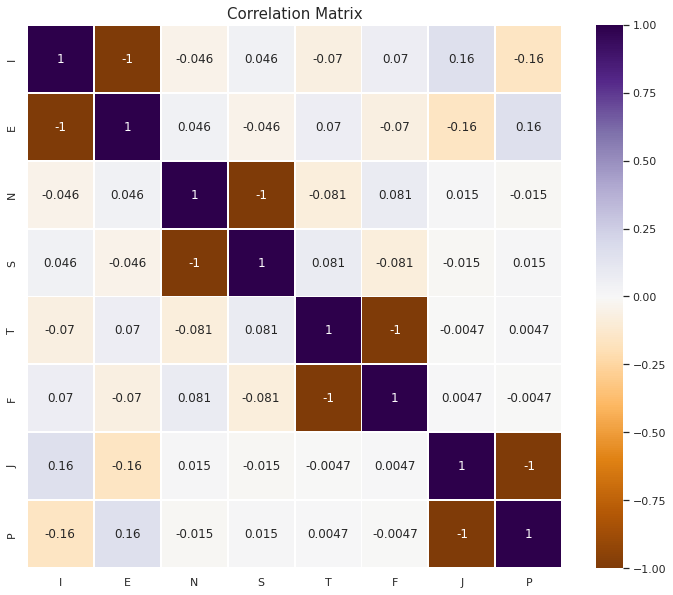

In [ ]:
#Correlation dataframe
corr_df = pd.DataFrame()

#Iterate over each type
for t in 'IENSTFJP':
    corr_df[t] = df['type'].apply(lambda x: 1 if t in x else 0)

#Calculate correlation
corr_mat = corr_df[['I','E','N','S','T','F','J','P']].corr()

#Plot the matrix
plt.figure(figsize=(12,10))
plt.title('Correlation Matrix', size=15)
sns.heatmap(corr_mat, cmap='PuOr',  annot=True, linewidths=1);

#Data Pre-processing

##Count Vectorizer

In [ ]:
#Download stopwords from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#Perform count vectorization
cv = CountVectorizer(analyzer="word", max_features=2000, strip_accents='ascii', stop_words=stop_words)

X_cnt = cv.fit_transform(df['posts'])

#Print the vocabulary words
# cv.vocabulary_.keys()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Term frequency-inverse document frequency

In [ ]:
#Convert to numpy array
X_cnt.toarray()

#Tfidf object
tfizer = TfidfTransformer()

#Perform Tfid
X_tfidf = tfizer.fit_transform(X_cnt).toarray()

#Create labels per personality trait
Y = pd.DataFrame()
for c in 'IENSTFJP':
    Y[c] = df['type'].apply(lambda x: 1 if c in x else 0)

#Machine Learning Algorithms

##Performance evaluation metrics

In [ ]:
#Personality traits
mbti = {'I':['Extroversion', 'Introversion'],
        'N':['Sensing', 'Intuition'],
        'T':['Feeling', 'Thinking'], 
        'J':['Perceiving', 'Judging']}

#Confusion matrix and Classification Report
def perf_eval(y_true, y_pred, trait):
    #Classification report
    print(classification_report(y_true, y_pred,
                                target_names=mbti[trait]))
    #Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    #Plot the figure
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix,
                cmap='Blues',
                annot=True,
                fmt="d",
                xticklabels=mbti[trait],
                yticklabels=mbti[trait])
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

##XGBoost

['Extroversion', 'Introversion'] ...
              precision    recall  f1-score   support

Extroversion       0.82      0.52      0.64       393
Introversion       0.87      0.97      0.92      1342

    accuracy                           0.87      1735
   macro avg       0.85      0.74      0.78      1735
weighted avg       0.86      0.87      0.85      1735



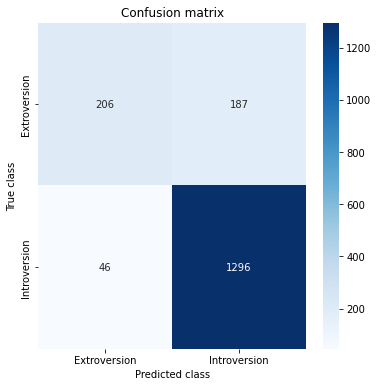

['Sensing', 'Intuition'] ...
              precision    recall  f1-score   support

     Sensing       0.79      0.32      0.46       237
   Intuition       0.90      0.99      0.94      1498

    accuracy                           0.90      1735
   macro avg       0.85      0.66      0.70      1735
weighted avg       0.89      0.90      0.88      1735



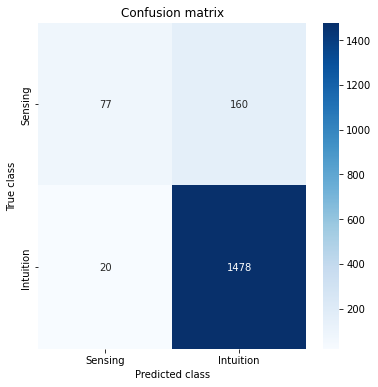

['Feeling', 'Thinking'] ...
              precision    recall  f1-score   support

     Feeling       0.83      0.84      0.84       932
    Thinking       0.81      0.80      0.81       803

    accuracy                           0.82      1735
   macro avg       0.82      0.82      0.82      1735
weighted avg       0.82      0.82      0.82      1735



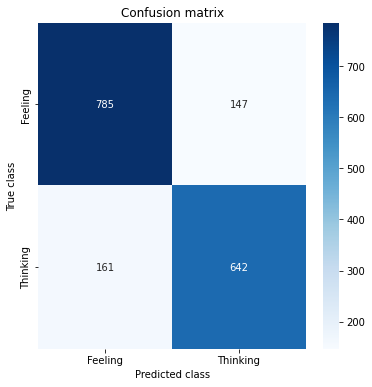

['Perceiving', 'Judging'] ...
              precision    recall  f1-score   support

  Perceiving       0.81      0.90      0.85      1072
     Judging       0.80      0.65      0.72       663

    accuracy                           0.80      1735
   macro avg       0.80      0.77      0.78      1735
weighted avg       0.80      0.80      0.80      1735



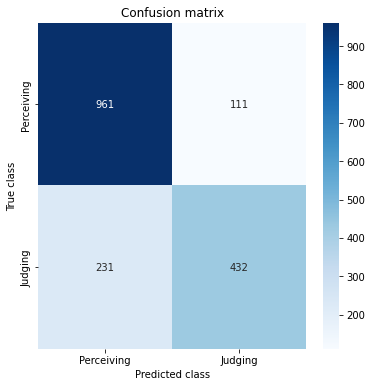

In [ ]:
#Create the model
xgb_model = XGBClassifier()

#Variable to store accuracy
xgb_accuracy = []

#Iterate over personality traits  
for i in 'INTJ':
    #Current Trait
    print("%s ..." % (mbti[i]))

    #Get labels of the current trait
    Y_part = Y[i]

    #Create training / testing data split
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y_part, test_size=0.2, random_state=7)

    #Model training
    xgb_model.fit(X_train, y_train)

    #Model prediction
    y_pred = xgb_model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    
    #Model evaluation
    perf_eval(y_test, predictions, i)

    #Store accuracy for each trait
    xgb_accuracy.append(accuracy_score(y_test, predictions))

##SVM

['Extroversion', 'Introversion'] ...
              precision    recall  f1-score   support

Extroversion       0.85      0.47      0.61       393
Introversion       0.86      0.98      0.92      1342

    accuracy                           0.86      1735
   macro avg       0.86      0.72      0.76      1735
weighted avg       0.86      0.86      0.85      1735



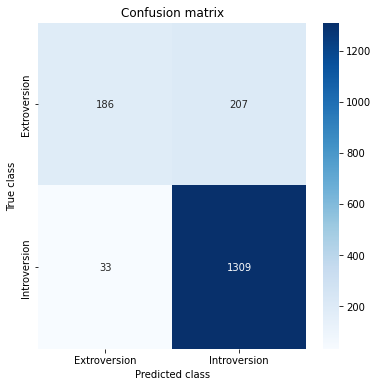

['Sensing', 'Intuition'] ...
              precision    recall  f1-score   support

     Sensing       0.86      0.29      0.44       237
   Intuition       0.90      0.99      0.94      1498

    accuracy                           0.90      1735
   macro avg       0.88      0.64      0.69      1735
weighted avg       0.89      0.90      0.87      1735



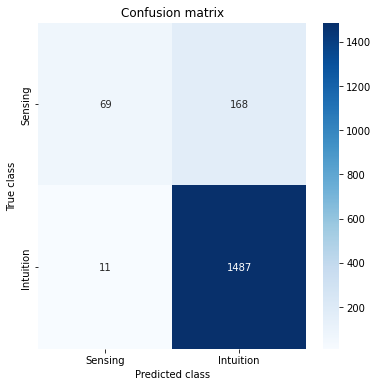

['Feeling', 'Thinking'] ...
              precision    recall  f1-score   support

     Feeling       0.86      0.87      0.86       932
    Thinking       0.84      0.83      0.84       803

    accuracy                           0.85      1735
   macro avg       0.85      0.85      0.85      1735
weighted avg       0.85      0.85      0.85      1735



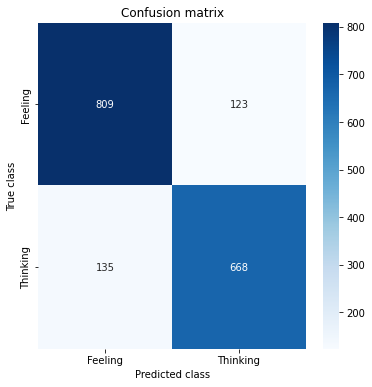

['Perceiving', 'Judging'] ...
              precision    recall  f1-score   support

  Perceiving       0.81      0.91      0.85      1072
     Judging       0.81      0.65      0.72       663

    accuracy                           0.81      1735
   macro avg       0.81      0.78      0.79      1735
weighted avg       0.81      0.81      0.80      1735



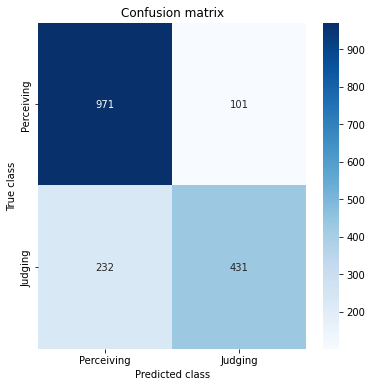

In [ ]:
#Create the model
svm_model = SVC(kernel='rbf')

#Variable to store accuracy
svm_accuracy = []

#Iterate over personality traits  
for i in 'INTJ':
    #Current Trait
    print("%s ..." % (mbti[i]))

    #Get labels of the current trait
    Y_part = Y[i]

    #Create training / testing data split
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y_part, test_size=0.2, random_state=7)

    #Model training
    svm_model.fit(X_train, y_train)

    #Save the model
    pickle.dump(svm_model, open(i, 'wb'))

    #Model prediction
    y_pred = svm_model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    
    #Model evaluation
    perf_eval(y_test, predictions, i)

    #Store accuracy for each trait
    svm_accuracy.append(accuracy_score(y_test, predictions))

##Accuracy comparison

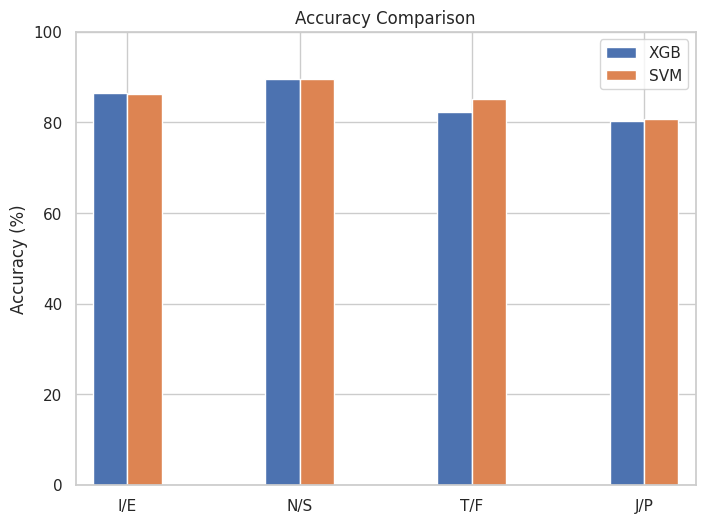

In [ ]:
#Total traits
x = np.arange(4)

#Algorithm's accuracy
c1 = np.asarray(xgb_accuracy)*100
c2 = np.asarray(svm_accuracy)*100

#Plot accuracies
sns.set_theme(style='whitegrid', palette='deep')
plt.figure(figsize=(8,6), dpi=100)
  
# plot data in grouped manner of bar type
width = 0.2
plt.bar(x-0.2, c1, width, color='C0')
plt.bar(x, c2, width, color='C1')

#Label the plot
plt.title("Accuracy Comparison")
plt.xticks(x-0.1, ['I/E', 'N/S', 'T/F', 'J/P'])
plt.ylabel("Accuracy (%)")
plt.legend(["XGB", "SVM"],loc='upper right')
plt.xlim([-0.4, 3.2])
plt.ylim([0, 100])
plt.show()

#Predictions

In [ ]:
#Load trained models
IE_model = pickle.load(open('I', 'rb'))
NS_model = pickle.load(open('N', 'rb'))
TF_model = pickle.load(open('T', 'rb'))
JP_model = pickle.load(open('J', 'rb'))

In [ ]:
#Pick a user
pick = 10

#Print the post text
df.loc[pick,'posts']

"'One time my parents were fighting over my dad's affair and my dad pushed my mom. The fall broke her finger.  She's pointed a gun at him and made him get on his knees and beg for his life. She's...|||I'm gonna talk about what a piece of shit my dad is now.  He's an alcoholic and he has some kind of serious mental problem when it comes to complying with the IRS. (In his words, Laws don't apply...|||OMG...at the women's center I lived at, run by a Catholic charity, the fat bully program manager took it upon herself to change policy so that tenants were FORCED to attend the Christmas party. If...|||I don't work, but I have a calling I am 100% committed to 24/7 with no vacation or off days EVER. I'm a Kundalini mystic.  Oh, I don't get paid, either!  It's one of those destined things...|||My art teacher in high school had a stack of art school catalogs. When I saw the one for the school I ended up going to, I immediately knew that was the one. Without any research. It was like when...|||I

In [ ]:
#Pre-process the text
user = df.loc[pick,'posts']
user_vec = cv.transform([user])
user_tf = tfizer.transform(user_vec).toarray()

#Perform predictions using the trained models
user_traits = [mbti['I'][int(IE_model.predict(user_tf))], 
               mbti['N'][int(NS_model.predict(user_tf))],
               mbti['T'][int(TF_model.predict(user_tf))],
               mbti['J'][int(JP_model.predict(user_tf))]]

print("The predicted personality traits of the user are: ", user_traits)

print("The correct personality traits of the user are: ", df.loc[pick,'type'])

The predicted personality traits of the user are:  ['Introversion', 'Intuition', 'Feeling', 'Judging']
The correct personality traits of the user are:  INFJ
